In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp



warnings.filterwarnings("ignore")
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
sells_df = pd.read_csv('sell_prices.csv')

In [3]:
sells_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [3]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sells_df = downcast(sells_df)

In [4]:
sells_df.shape

(6841121, 4)

In [6]:
sells_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,NaN
std,1.486100e+02,0.000000e+00
min,1.110100e+04,1.000214e-02
25%,1.124700e+04,2.179688e+00
50%,1.141100e+04,3.470703e+00
75%,1.151700e+04,5.839844e+00
max,1.162100e+04,1.073125e+02


In [14]:
sells_df.columns

Index(['store_id', 'item_id', 'wm_yr_wk', 'sell_price'], dtype='object')

In [19]:
store_counts = sells_df['store_id'].unique()
print(store_counts)

['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3']


In [13]:
item_counts = sells_df['item_id'].value_counts()
print(item_counts)

HOUSEHOLD_1_087    2820
HOBBIES_1_164      2820
HOBBIES_1_233      2820
HOUSEHOLD_2_030    2820
HOUSEHOLD_2_033    2820
                   ... 
HOUSEHOLD_1_308     642
HOUSEHOLD_1_159     623
HOUSEHOLD_1_242     600
FOODS_3_296         592
FOODS_2_379         530
Name: item_id, Length: 3049, dtype: int64


***Distribution of Sell Prices***

In [28]:
import plotly.express as px

fig = px.histogram(sells_df, x='sell_price', nbins=30, title='Distribution of Sell Prices', labels={'sell_price': 'Sell Price', 'count': 'Frequency'})
fig.update_traces(marker_color='royalblue', selector=dict(type='histogram'))
fig.update_layout(xaxis_title='Sell Price', yaxis_title='Frequency')
***fig.show()


***there are a few items with very high sell prices, but most items have much lower sell prices.***



In [27]:
fig = px.box(sells_df, x='store_id', y='sell_price', title='Sell Price Variation by Store', labels={'store_id': 'Store ID', 'sell_price': 'Sell Price'})
fig.updateb
_layout(xaxis_tickangle=-45)
fig.show()

***There are some outliers for some stores. These are the data points that fall outside the boxplots. Outliers can be caused by a variety of factors, such as data entry errors or unusual events.***


***Sell Price Correlation Heatmap***

In [26]:
import plotly.graph_objs as go

correlation_heatmap = sell_prices_pivot.corr()

fig = go.Figure(data=go.Heatmap(
                   z=correlation_heatmap.values,
                   x=correlation_heatmap.columns,
                   y=correlation_heatmap.columns,
                   colorscale='Viridis'))

fig.update_layout(
    title='Sell Price Correlation Heatmap',
    xaxis=dict(title='Store ID'),
    yaxis=dict(title='Store ID')
)
fig.update_layout(showlegend=True, height=750)
fig.show()


***Average Price by Store Over Time***

In [29]:
import plotly.express as px

average_prices = sells_df.groupby(['store_id', 'wm_yr_wk'])['sell_price'].mean().reset_index()

fig = px.line(
    average_prices,
    x='wm_yr_wk',
    y='sell_price',
    color='store_id',
    title='Average Price by Store Over Time',
    labels={'wm_yr_wk': 'Week (wm_yr_wk)', 'sell_price': 'Average Sell Price', 'store_id': 'Store ID'},
)

fig.update_xaxes(tickangle=45)
fig.update_layout(showlegend=True, height=600)  # Increase the height to 600 pixels
fig.update_layout(showlegend=True)
fig.show()


***The average sell price for all stores tends to increase over time.***

***Let's first look at the distribution of prices across Categories***

In [4]:
sells_df["Category"] = sells_df["item_id"].str.split("_",expand = True)[0]

Text(0.5, 1.0, 'Density plot of log of prices accross Categories')

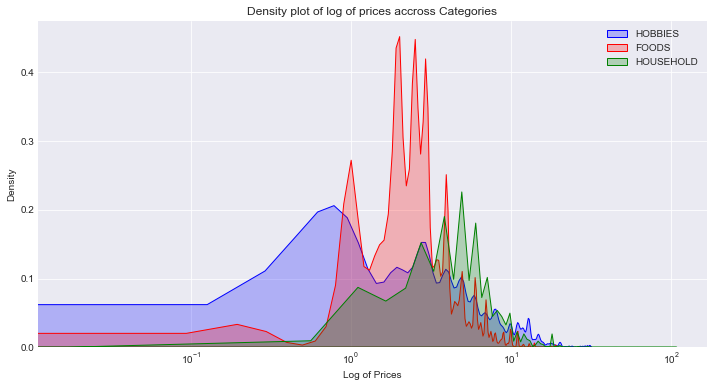

In [5]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(sells_df[sells_df['Category']=='HOBBIES']['sell_price'], shade=True, color="b")
p2=sns.kdeplot(sells_df[sells_df['Category']=='FOODS']['sell_price'], shade=True, color="r")
p3=sns.kdeplot(sells_df[sells_df['Category']=='HOUSEHOLD']['sell_price'], shade=True, color="g")
plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

***What we see:***

-   ***Most of the prices for food products lie between 1 dollars and 10 dollars. As we can see the high peak between 10^0 and 10^1***
-   ***Hobbies show a pretty wide range of prices***
-   ***Households are costlier than Food***



In [19]:
#Let's look at items with the maximum price change and minimum price change over the years
item_store_prices = sells_df.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]                                               
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]

In [20]:
print("Items sorted by maximum price change over the years (top 10)")
item_store_prices_sorted.head(10)

Items sorted by maximum price change over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOUSEHOLD_2_406,WI_3,107.312500,3.259766,104.062500,HOUSEHOLD
1,HOUSEHOLD_2_406,WI_2,61.468750,12.460938,49.000000,HOUSEHOLD
2,HOUSEHOLD_2_466,TX_1,52.625000,6.460938,46.156250,HOUSEHOLD
3,HOUSEHOLD_2_178,TX_1,44.375000,3.000000,41.375000,HOUSEHOLD
4,HOUSEHOLD_2_250,WI_2,34.187500,3.359375,30.828125,HOUSEHOLD
5,HOUSEHOLD_2_406,WI_1,35.875000,9.968750,25.906250,HOUSEHOLD
6,HOUSEHOLD_2_250,WI_1,30.312500,4.968750,25.343750,HOUSEHOLD
7,HOUSEHOLD_1_469,WI_3,19.968750,1.000000,18.968750,HOUSEHOLD
8,HOUSEHOLD_2_514,TX_2,19.546875,1.000000,18.546875,HOUSEHOLD
9,HOUSEHOLD_1_342,WI_3,17.968750,1.000000,16.968750,HOUSEHOLD


***Notes:***
- ***We see that household items specially HOUSEHOLD_2 department has shown the maximum price changes specially in Wisconsin.***
- ***The price changed the most for HOUSEHOLD_2_406 item in WI_3 store where the min price was just 3.26 dollors and had rised 32 times to 107 dollors***
- ***FOODS_1_014 item hasnt changed prices over the years. Also, the price is fixed in all stores***

In [30]:
fig = px.box(
    item_store_prices_sorted,
    x="price_change",
    y="category",
    title="Boxplot for Maximum Price Change for Each Item Over the Years Across All Categories",
    labels={"price_change": "Price Change", "category": "Category"}
)

fig.show()



***Notes:***

-   ***Most products dont change prices at all and most changes are restricted to 10-15$***
-    ***Household items have the highest price changes over the years***

